# Std Deviation of $\phi_{i-1} - \phi_i$ as a function of sampling frequency $f_s$

This is a jupyter notebook to see if the std-dev of histogram of deltas decreases with increased sampling frequency.

In [1]:
# . Honours Module Folder
# ├ FYPLibrary
# | ├ file_reading.py
# | └ IQ_demod.py
# └ Sub Project folder i.e.: os.path.abspath('')
#   ├ this notebook(.ipynb)
#   └ "Batch" folder
#     └ C2-xxxHz-xxxmVpp-80.125xxxMHz-comment.txt

# Initialization: Directory appending for my system. Vary the directories as necessary.
import sys
import os.path
# Add the FYPLibrary folder in the same level as this folder.
parent_dir = os.path.dirname(os.path.abspath(''))
if os.path.join(parent_dir, 'FYPLibrary') not in sys.path:
    sys.path.append(os.path.join(parent_dir, 'FYPLibrary'))
del parent_dir

# from pprint import pprint
# pprint(sys.path)

# within this jupyter notebook
from os import listdir
from file_reading import *
from IQ_demod import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

from scipy.optimize import curve_fit
from numpy import pi as pi
from scipy.stats import norm
from scipy.stats import cauchy

In [52]:
def get_files():
    # uses tkinter to get the paths. returns all files as selected by UI
    # tkinter will not allow for extracting files from multiple folders
    import tkinter as tk
    from tkinter import filedialog

    root = tk.Tk()
    root.withdraw()
    fs = filedialog.askopenfilenames(initialdir= os.path.dirname(os.path.abspath('')), 
        title="Select files")
    return fs

def get_folder():
    # uses tkinter to get a folder
    import tkinter as tk
    from tkinter import filedialog

    root = tk.Tk()
    root.withdraw()
    my_dir = filedialog.askdirectory(initialdir= os.path.dirname(os.path.abspath('')), 
        title="Select directory")
    return my_dir

In [75]:
# Step 1: Change the name to which the folder you wish to read from
# Yield all files in batch folder
folderpath = get_folder()

files = listdir(path= folderpath)
for i, f in enumerate(files):
    print(f"{i:>3}: {f}")

  0: C1-1.0MHz-00000.trc
  1: C1-1.0MHz-00001.trc
  2: C1-1.0MHz-00002.trc
  3: C1-1.0MHz-00003.trc
  4: C1-1.0MHz-00004.trc
  5: C1-1.0MHz-00005.trc
  6: C1-1.0MHz-00006.trc


In [76]:
NAME = files[1]
file = os.path.join(folderpath, NAME)
print(f"{NAME = }\n{file = }")

NAME = 'C1-1.0MHz-00001.trc'
file = 'D:/20220316 130 meter cable/Batch 4/Batch 4F 8\\C1-1.0MHz-00001.trc'


In [77]:
# SAMPLING_F = 1.0
_, SAMPLING_F = numerical_variables_from_name(NAME)
SAMPLING_F *= 1e6
SIGNAL_F = (70e6 + SAMPLING_F/16)*2
print(f"SAMPLING_F = {SAMPLING_F/(1e6)} MHz")
print(f"SIGNAL_F/2 = {SIGNAL_F/(2e6)} MHz")

SAMPLING_F = 1.0 MHz
SIGNAL_F/2 = 70.0625 MHz


In [78]:
N, _ = freq_ratio(signal= SIGNAL_F, sample= SAMPLING_F)
ph_ad = phase_advance(SIGNAL_F, SAMPLING_F) # phase advance = 2*pi/N
print(f"{N = }\n{ph_ad = }")

N = 8
ph_ad = 0.7853981633974483


In [79]:
_, signal = fr.parse_and_read_oscilliscope_trc(file)
signal = signal[0]
signal -= np.mean(signal)
phases = signal_to_phase(signal, N, ph_ad, phase_advancement_correction= False)
phases_delta = phases
phases = phase_reconstruction_2(phases, ph_ad)
deltas = phase_reconstruction_2(phases_delta, 2*pi/N, get_deltas= True)

if np.max(phases) - np.min(phases) > 1e5:
    print("DRIFTING")
    exit()
    

[Log] file supplied = D:/20220316 130 meter cable/Batch 4/Batch 4F 8\C1-1.0MHz-00001.trc
[Log] meta is not embedded


In [80]:
meta =  {'Record Length': (len(signal), 'Points'), \
        'Sample Interval': (1/SAMPLING_F, 's'), \
        'Trigger Point': ('unknown', 'Samples'), \
        'Trigger Time': ('unknown', 's'), \
        'Horizontal Offset': ('unknown', 's')}

In [81]:
t_axis = np.arange(start= 0, 
        stop= (int(meta["Record Length"][0])-N+1) * meta['Sample Interval'][0], step= meta['Sample Interval'][0])

In [82]:
radii = get_R_signal(signal, N, ph_ad)

General measures

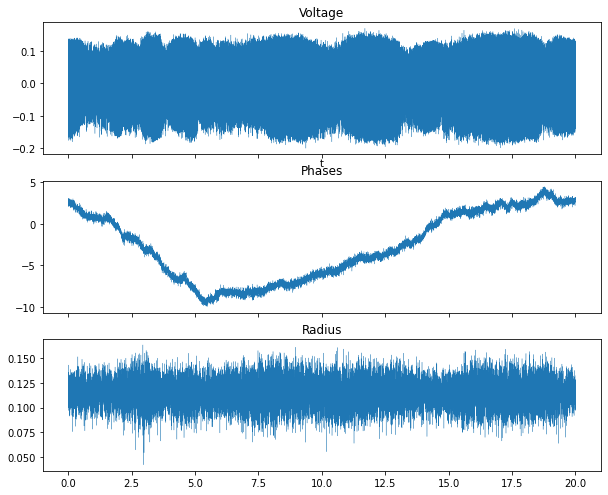

In [83]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex= True)
ax = axs[0]
ax.set_xlabel(r't', usetex= False)
ax.plot(t_axis[::10**2], signal[N-1::10**2], linewidth= 0.3)
ax.set_title(r'Voltage')

ax = axs[1]
ax.plot(t_axis[::10**3], phases[::10**3], linewidth= 0.3)
ax.set_title(r'Phases')
# ax.set_ylim(phases[-1]-70, phases[-1]+70)

ax = axs[2]
ax.set_title(r'Radius')
ax.plot(t_axis[::10**3], radii[::10**3], linewidth= 0.3)
# ax.set_xlim([25, 50])

fig.set_size_inches(10, 8.25)

## Histogram of $\delta$

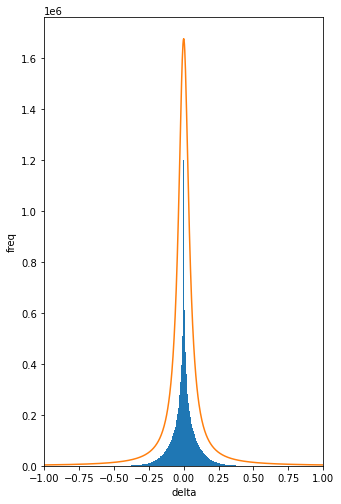

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=1)
my_hist = ax.hist(deltas, bins= 615)
# ax.set_yscale('log')
ax.set_ylabel(r'freq', usetex = False)
ax.set_xlabel(r'delta', usetex = False)
# fig.set_size_inches(11.75-1.5, 8.25-2 - 1)
ax.set_xlim(-1, 1)
fig.set_size_inches(5, 8.25)
my_gamma = 0.045
my_rv = ss.cauchy()
x = np.arange(-pi, pi, pi/1230)
my_line = len(deltas)/3.8 * my_rv.pdf(x/my_gamma) 
h = plt.plot(x, my_line)

In [85]:
np.std(deltas)

0.0869383702472209

## Plot of $\phi_d$ over time

In [86]:
t_axis = np.arange(start= 0, 
        stop= (int(meta["Record Length"][0])-N+1) * meta['Sample Interval'][0], step= meta['Sample Interval'][0])

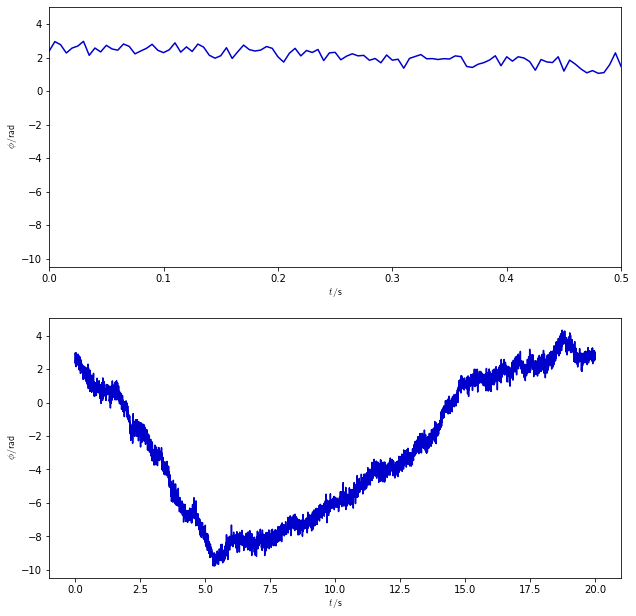

In [87]:
if np.max(phases) - np.min(phases) < 2e4:
    fig, axs = plt.subplots(nrows=2, ncols=1)
    ax = axs[0]
    ax.plot(t_axis[::5000], phases[::5000], color = 'mediumblue')
    ax.set_ylabel(r'$\phi$/rad', usetex = True)
    ax.set_xlabel(r'$t$/s', usetex = True)
    ax.set_xlim(0, 0.5)
    ax = axs[1]
    ax.plot(t_axis[::5000], phases[::5000], color = 'mediumblue')
    ax.set_ylabel(r'$\phi$/rad', usetex = True)
    ax.set_xlabel(r'$t$/s', usetex = True)
    fig.set_size_inches(11.75-1.5, (8.25-2 - 1)*2)
else:
    print("DRIFTIng")

Distribution in delta, and fitting to normal/cauchy

In [88]:
def r_squared(predicted_y, data_y):
    absE = predicted_y - data_y
    return 1.0 - (np.var(absE)/np.var(data_y))

def adjusted_r_squared(predicted_y, data_y, p):
    # p is the number of explainatory variables
    # print(f"[Debug] {predicted_y.size = }")
    return 1- (1-r_squared(predicted_y, data_y)) \
        *(predicted_y.size - 1)/(predicted_y.size - p)

In [89]:
def my_normal(x,A,mu,sigma):
    return A*np.exp(-np.power(x-mu,2)/(2*np.power(sigma,2))) / (np.sqrt(2*pi)*sigma)

def normal_jac(x, A, mu, sigma):
    # returns partial f_i /partial x_j, which is just df/dx in our case
    # return np.array((-2*.5*(1 - x[0]) - 4*x[0]*(x[1] - x[0]**2), 
    #     2*(x[1] - x[0]**2)))
    # return - A * np.exp(-np.power(x-mu,2)/(2*np.power(sigma,2))) * (x-mu) / (np.sqrt(2*pi)*np.power(sigma,3))
    return np.transpose(np.array((np.exp(-np.power(x-mu,2)/(2*np.power(sigma,2))) / (np.sqrt(2*pi)*sigma),
        A * np.exp(-np.power(x-mu,2)/(2*np.power(sigma,2))) * (x-mu) / (np.sqrt(2*pi)*np.power(sigma,3)),
        - A * np.exp(-np.power(x-mu,2)/(2*np.power(sigma,2))) * sigma / (np.sqrt(2*pi)*np.power(sigma,3)) + A * np.exp(-np.power(x-mu,2)/(2*np.power(sigma,2))) * np.power(x-mu,2) / (np.sqrt(2*pi)*np.power(sigma,4)) )))

def my_cauchy(x,A,mu,gamma):
    return A/(pi*gamma*(1+np.power((x-mu)/gamma,2)))

def my_logistic(x, A, mu, s):
    return A/(4*s * np.power(np.cosh((x-mu)/(2*s)),2))

def my_laplace(x,A,mu,b):
    return A*np.exp(-np.abs(x-mu)/b)/(2*b)

In [90]:
step = 2*pi/(pi/1230)
xmin= -pi
xmax= pi

In [91]:
y, x = np.histogram(deltas, bins=np.arange(xmin, xmax, (xmax-xmin)/step))
nbins = y.size
x=x[:-1]

In [92]:
norm_popt, norm_pcov = curve_fit(my_normal, x, y,
    p0= [deltas.size, 0, np.std(deltas)], jac= normal_jac)
print(norm_popt)
print(norm_popt[0]/deltas.size)
norm_adjr = adjusted_r_squared(my_normal(x, *norm_popt), y, 3)
print(f"{norm_adjr = }")

[ 3.71326885e+04 -1.19195768e-03  3.27288205e-02]
0.0018566349839941243
norm_adjr = 0.8488145123882345


In [93]:
cauchy_popt, cauchy_pcov = curve_fit(my_cauchy, x, y,
    p0= [deltas.size, 0, np.std(deltas)])
print(cauchy_popt)
cauchy_adjr = adjusted_r_squared(my_cauchy(x, *cauchy_popt), y, 3)
print(f"{cauchy_adjr = }")

[ 4.56295291e+04 -1.22678783e-03  2.55412218e-02]
cauchy_adjr = 0.927398822153175


In [94]:
logis_popt, logis_pcov = curve_fit(my_logistic, x, y,
    p0= [deltas.size, 0, np.std(deltas)])
print(logis_popt)
logis_adjr = adjusted_r_squared(my_logistic(x, *logis_popt), y, 3)
print(f"{logis_adjr = }")

[ 3.83935557e+04 -1.20221056e-03  2.01571044e-02]
logis_adjr = 0.8708592802570392


In [95]:
lap_popt, lap_pcov = curve_fit(my_laplace, x, y,
    p0= [deltas.size/3, 0, np.std(deltas)])
print(lap_popt)
lap_adjr = adjusted_r_squared(my_laplace(x, *lap_popt), y, 3)
print(f"{lap_adjr = }")

[ 4.29314878e+04 -1.15459279e-03  3.50806167e-02]
lap_adjr = 0.9388588659843197


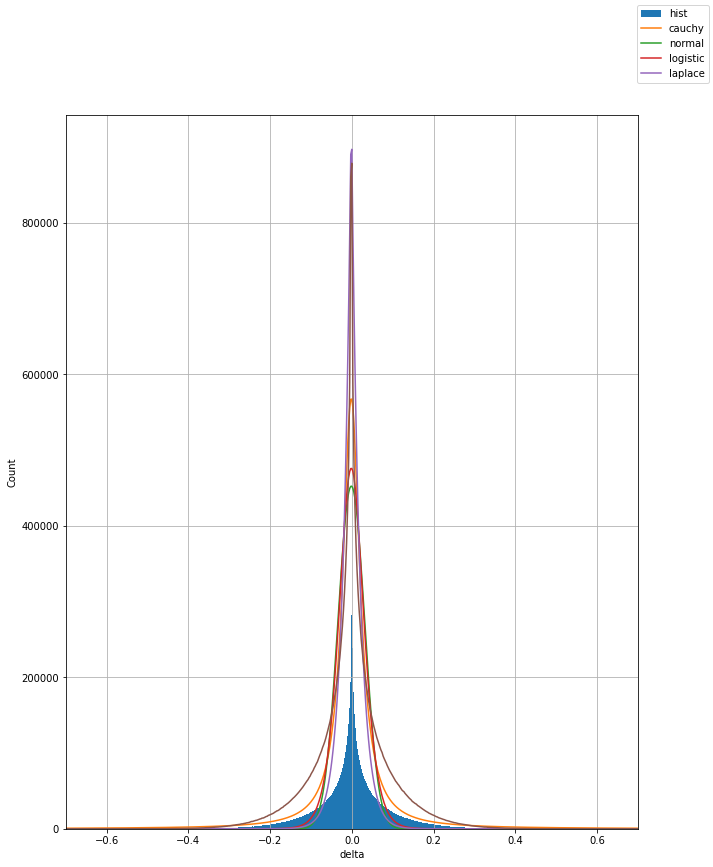

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1)
# ax.bar(x[:-1], y, width=x[1]-x[0], color= 'blue', alpha= 0.2, label= 'hist')
ax.hist(deltas, bins=nbins, label= 'hist')
ax.plot(x, my_cauchy(x, *cauchy_popt), label= 'cauchy')
ax.plot(x, my_normal(x, *norm_popt), label= 'normal')
ax.plot(x, my_logistic(x, *logis_popt), label= 'logistic')
ax.plot(x, my_laplace(x, *logis_popt), label= 'laplace')
ax.plot(x,y)
ax.grid(True)
ax.set_xlim([-0.7, 0.7])
ax.set_ylabel(r'Count', usetex = False)
ax.set_xlabel(r'delta', usetex = False)

fig.legend()
fig.set_size_inches(11.75-1.5, 2.5*(8.25-2 - 1))

